# TL;DR

This notebook is used to run experiments for offline data analysis section in the Aquarius paper. 

# Import libs & utils fn

In [1]:
import sys
import os
utils_dir = '../../src/utils'
sys.path.insert(0, utils_dir) # add utils dir to path
import testbed_utils as tu
import time
from scipy import stats
import numpy as np
import json
import pandas as pd

In [2]:
# configure the MACROs here
EXPERIMENT = 'online'
DATA_DIR = '../../data/reproduce/{}'.format(EXPERIMENT)
USER = 'yzy'
GLOBAL_CONF = tu.json_read_file('../../config/global_conf.json')
ROOT_DIR = GLOBAL_CONF['dir']['root']
# local machine hostname
LOCAL_MACHINE = !hostname
LOCAL_MACHINE = LOCAL_MACHINE[0]
SERVER_IPS = GLOBAL_CONF['net']['physical_server_ip']
# local machine ID
LOCAL_ID = SERVER_IPS.index(LOCAL_MACHINE)
REMOTE_IDS = [i for i, v in enumerate(SERVER_IPS) if v != LOCAL_MACHINE]
SHM_LAYOUT = tu.json_read_file("../../src/lb/dev/shm_layout_base.json")
FEATURE_AS_CNT = [_[1] for _ in SHM_LAYOUT["vpp"]["struct"]["as_stat"][1:]] # counter features gathered for each AS in as_stat_t
FEATURE_AS_RES = [_[1] for _ in SHM_LAYOUT["vpp"]["struct"]["reservoir_as"]] # features gathered for each AS w/ reservoir sampling
RES_FEATURE_ENG = ["avg", "90", "std", "avg_decay", "90_decay"]
FEATURE_AS_ALL = FEATURE_AS_CNT + ["_".join((a, b)) for a in FEATURE_AS_RES for b in RES_FEATURE_ENG]
GT = ["cpu", "memory", "apache", "asid"]

## For running experiments

In [3]:
def run_pipeline(
    lb_method = 'aquarius_ecmp',
    trace='wiki',
    experiment='offline',
    sample='hour0.csv',
    from_orig=False,
    config_file_prefix='1lb-36core',
    clip_n=20000,
    n_episode=1,
    episode_base=0,
    remote_servers=[0, 2, 3],
    clt_server=0,
):
    '''
    @brief: run a set of experiments with a specific setup
    @params:
        lb_method: method name defined in config/lb_methods.json
        trace: trace type as in data/trace/*
    '''
    global USER, ROOT_DIR, LOCAL_ID, REMOTE_IDS, SERVER_IPS
    assert set(remote_servers) - set(REMOTE_IDS) == set()
    config_file = config_file_prefix+'-'+str(LOCAL_ID)
    config_file_remote = {i: config_file_prefix+'-{}'.format(i) for i in REMOTE_ID}

    for episode in range(episode_base, episode_base+n_episode):
    
        task_name, task_dir, nodes = tu.init_task_info(
            experiment=experiment,
            lb_method=lb_method,
            trace=trace,
            sample=sample,
            filename=config_file+'.json',
            colocate=colocate,
            colocate_freq=colocate_freq,
            alias=config_file_prefix,
        )

        print(">> run task {} - episode {}".format(task_name, episode))

        #--- spin up ---#
        for server_id in remote_servers:
            cmd = 'ssh -t {}@{} "python3 {}/src/utils/run_server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
                USER, SERVER_IPS[server_id], ROOT_DIR, experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id])

            if colocate:
                cmd += ' --colocate {}'.format(colocate)
            if clip_n and server_id == 0:
                cmd += ' -n {}'.format(clip_n)
            tu.subprocess.Popen(cmd, shell=True)
        

        tu.prepare_img(lb_method=lb_method, from_orig=from_orig, debug_node=False)

        tu.runall()
        time.sleep(10)
        
        #--- check network ---#

        net_ok = False
        while not net_ok:
            try:
                tu.gt_socket_check()
                net_ok = True
            except:
                print('error')
                time.sleep(1)

        time.sleep(3)

        # start gathering at LB node
        for lb in tu.NODES['lb']:
            lb.run_init_bg()

        # run traffic
        t0 = time.time()
        cmd = 'ssh -t {}@{} "python3 {}/src/utils/run_traffic.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json"'.format(
            USER, SERVER_IPS[clt_server], ROOT_DIR, experiment, colocate_freq, lb_method, trace, sample, config_file_remote[0])
        tu.subprocess_cmd(cmd)
        print("Trace replay over w/ total time: {:.3f}s".format(time.time()-t0))
        time.sleep(5)

        # fetch results from nodes
        for server_id in REMOTE_IDS:
            cmd = 'ssh -t {}@{} "python3 {}/src/utils/shutdown_server.py --experiment {} --colocate-freq {} -m {} --tr {} --sample {} -f {}.json --episode {}"'.format(
                USER, SERVER_IPS[server_id], ROOT_DIR, experiment, colocate_freq, lb_method, trace, sample, config_file_remote[server_id], episode)
            tu.subprocess.Popen(cmd, shell=True)

        for lb in tu.NODES['lb']:
            lb.fetch_result(task_dir, episode)

        tu.shutall()

## Data Processing

In [6]:
def get_page_load_time(filename, ep=None, verbose=False):
    traces = !ls {filename}
    traces = [t for t in traces if 'trace' in t]
    if ep:
        if ep == -1:
            traces = [t for t in traces if 'ep' not in t]
        else:
            traces = [t for t in traces if 'ep{}'.format(ep) in t]

    
    page_load_time = []
    page_load_time_wiki = []
    page_load_time_static = []
    n_timeout = 0
    n_reset = 0
    n_sent = 0
    n_encode = 0
    n_404 = 0
    n_closed = 0
    
    for t in traces:
        if verbose: print("parsing trace {}".format(t))
        plt_all, plt_wiki, plt_static = [], [], []
        wiki_log = tu.read_file(os.path.join(filename, t))
        for line in wiki_log:
            _ = line.split(' ')[-1]
            if ' failed ' not in line:
                plt_all.append(float(_))
                if 'wiki/index.php' in line:
                    plt_wiki.append(float(_))
                else:
                    plt_static.append(float(_))
                
            elif '[Errno 110]' in line:
                n_timeout += 1
            elif '[Errno 104]' in line:
                n_reset += 1
            elif 'Request-sent' in line:
                n_sent +=1
            elif 'HTTP_404' in line:
                n_404 += 1
            elif "\'ascii\' codec can\'t encode" in line:
                n_encode += 1
            elif "closed connection without response" in line:
                n_closed += 1
            else:
                print(line)
        
        # log if verbose
        if verbose:
            for k, plt_ in zip(['all', 'wiki', 'static'], [plt_all, plt_wiki, plt_static]):
                plt_ = np.array(plt_)
                print("plt {}: mean - {:.4f} median - {:.4f} 99p - {:.4f}".format(k, plt_.mean(), np.median(plt_), np.percentile(plt_, 99)))
        page_load_time += plt_all
        page_load_time_wiki += plt_wiki
        page_load_time_static += plt_static

    return {
        'page_load_time': page_load_time, 
        'plt_wiki': page_load_time_wiki, 
        'plt_static': page_load_time_static, 
        'timeout': n_timeout, 
        'n_reset': n_reset,
        'n_sent': n_sent,
        'n_404': n_404
    }
    

## Plot

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

COLORS_DICT = {
    'aqualb': "#508fc3", 
    'active-wcmp': '#559d3f',
    'wcmp': "#ef8532", 
    'ecmp': "#d1342b", 
    'maglev': "#d1342b", 
}

MARKER_DICT = {
    'aqualb':    "x",
    'active-wcmp': "o",
    'wcmp':   "+",
    'ecmp':   ".",
    'maglev':   ".",
}

LINESTYLE_DICT = {
    'active-wcmp': '-',
    'ecmp':       "-",
    'maglev':       "-",
    'aqualb':    "-",
    'wcmp':   "-",
}

METHOD_MAPPER = {
    'aqualb': "AquaLB", 
    'active-wcmp': "Active WCMP",
    'wcmp': "WCMP", 
    'ecmp': "ECMP", 
    'maglev': "Maglev"
}

# Table of Contents

1. Poisson Traffic of PHP For-Loop Requests (section 4.2.2)
2. Impact of Server Capacity Difference (section 4.2.3)
3. 24-Hour WikiPedia Trace (section 4.2.4)
4. Overhead Analysis

##  Poisson Traffic of PHP For-Loop Requests

### Poisson For-Loop Trace

In [13]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'aqualb']
samples = ['rate_{}.csv'.format(i) for i in [350, 500]]
config_prefix = ['2lb-168cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
for method in methods:
    print("=== running method {} ===".format(method))
    for sample in samples:
        print(">> sample {}".format(sample))
        for config in config_prefix:
            run_pipeline(
                lb_method=method,
                trace=trace,
                experiment=EXPERIMENT,
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config,
                clip_n=clip_n,
                n_episode=n_episode,
                episode_base=episode_base
                remote_servers=remote_servers,
                clt_server=clt_server,
            )

### Load Dataset

In [21]:
# page load time
conf = '2lb-168cpu'
rates = [350, 500]
page_load_time_res = {}
for rate in rates:
    config = 'rate_{:d}-{}'.format(rate, conf)
    print("working on config:", config)
    page_load_time_res[rate] = {}
    for method in methods:
        print(">> loading method:", method)
        _task, _dir = tu.get_task_name_dir(EXPERIMENT, trace, method, sample='rate_{:d}'.format(rate), alias=conf)
        page_load_time_res[rate][method] = get_page_load_time(_dir.replace('results', 'reproduce'))

working on config: rate_350-2lb-168cpu
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
working on config: rate_500-2lb-168cpu
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb


In [35]:
# weights
method = 'aqualb'
config_fmt = "rate_{}-2lb-84core"
split_by = 24
ratio_str = r"$\frac{\overline{w}_{2CPU}}{\overline{w}_{1CPU}}$"
df_dict = {
    ratio_str: [],
    'Traffic Rate': [],
    'Ratio Type': [],
    'Time': []
}
for rate in rates:
    config = 'rate_{:d}-{}'.format(int(rate), conf)
    for ep in [0]:
        lines = tu.read_file("../../data/reproduce/{}/{}/{}/{}/0_log_ep{}/logger.log".format(EXPERIMENT, trace, method, config, ep))[22:]
        for l in lines:
            if "Time: " in l:
                t = float(l.split('Time: ')[-1].strip(" ").strip("s)"))
            if '#apache: ' in l:
                values = [int(n) for n in l.split('#apache:')[-1].split('|')]
                df_dict[ratio_str].append(np.mean(values[:split_by])/np.mean(values[split_by:]))
                df_dict['Traffic Rate'].append(rate)
                df_dict['Ratio Type'].append('Apache')
                df_dict['Time'].append(t)
            elif 'Last action: ' in l:
                values = [float(n) for n in l.split('Last action:')[-1].split('|')]
                df_dict[ratio_str].append(np.mean(values[:split_by])/np.mean(values[split_by:]))
                df_dict['Traffic Rate'].append(rate)
                df_dict['Ratio Type'].append('AquaLB Weights')
                df_dict['Time'].append(t)
            else:
                continue
df_ratio = pd.DataFrame.from_dict(df_dict)

/home/yzy/.conda/envs/lb/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


### Plot

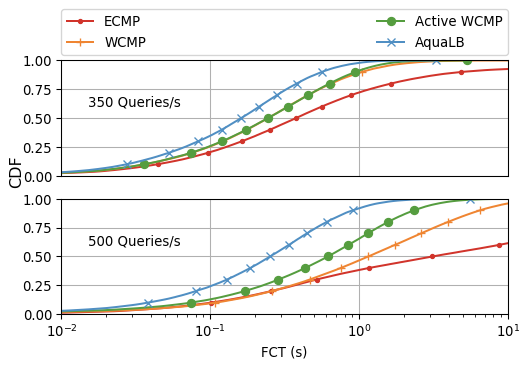

In [19]:
xlims=[[1e-2, 10],[1e-2, 10]]
n_subplots = 2
# xlim=None
fig, axs = plt.subplots(n_subplots, figsize=(6, 3.5), dpi=96, sharex=False, sharey=True)
fig.suptitle('CDF', position=(0.048, .6), rotation='vertical')
for i, ylabel, xlim in zip(range(n_subplots), [350, 500], xlims):
    for method in methods:
        if method in ['hlb']: continue
        v = page_load_time_res[ylabel][method]['page_load_time']
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
        axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    axs[i].text(1.5e-2, 0.6, '{} Queries/s'.format(ylabel))
    if i == n_subplots-1: axs[i].set_xlabel('FCT (s)')
    if i == 0: 
        axs[i].legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
           ncol=2, mode="expand", borderaxespad=0.)
        axs[i].set_xticks([1e-1, 1], ['', ''])
        axs[i].tick_params(axis='x', colors='w', which='both')

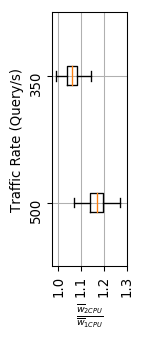

In [37]:
r = np.array(range(len(rates)))
method = 'aqualb'
f = plt.figure(figsize=(1, 3.5), dpi=96)
plt.boxplot([df_ratio.loc[(df_ratio['Traffic Rate'] == rate) & (df_ratio['Ratio Type'] == 'AquaLB Weights')][ratio_str].values for rate in rates[::-1]],
                    positions=r, showfliers=False, notch=False, vert=False)
plt.yticks(r, rates[::-1], rotation=90)
plt.ylabel('Traffic Rate (Query/s)')
plt.xlabel('{}'.format(ratio_str))
plt.xticks([1., 1.1, 1.2, 1.3], [1., 1.1, 1.2, 1.3], rotation=90)
plt.grid(True)

## Impact of Server Capacity Difference

### Poisson For-Loop Trace

In [34]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'aqualb']
samples = ['rate_{}.csv'.format(i) for i in [400]]
config_prefix = ['1x-2lb-168cpu', '4x-2lb-168cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
for method in methods:
    print("=== running method {} ===".format(method))
    for sample in samples:
        print(">> sample {}".format(sample))
        for config in config_prefix:
            run_pipeline(
                lb_method=method,
                trace=trace,
                experiment=EXPERIMENT,
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config,
                clip_n=clip_n,
                n_episode=n_episode,
                episode_base=episode_base
                remote_servers=remote_servers,
                clt_server=clt_server,
            )        

### Load Dataset

In [11]:
for method in methods:
    files = !ls ../../data/reproduce/online/poisson_for_loop/{method}
    for f in files:
        if '84core' in f:
            fs = f.split('84core')[0]
            !mv ../../data/reproduce/online/poisson_for_loop/{method}/{f} ../../data/reproduce/online/poisson_for_loop/{method}/{fs}168cpu

In [39]:
# page load time
methods = ['aqualb', 'active-wcmp', 'wcmp']
configs = ['1x-2lb-168cpu', '2lb-168cpu', '4x-2lb-168cpu']
rates = [400]
fct_all = {}
for setup in configs:
    print("====== setup: {} ======".format(setup))
    fct_all[setup] = {}
    for method in methods:
        print("=== method:", method, "===")
        fct_all[setup][method] = {}
        for rate in rates:
            print(">> rate:", rate)
            _task, _dir = tu.get_task_name_dir(EXPERIMENT, trace, method, sample='rate_{:d}'.format(rate), alias=conf)
            fct_all[setup][method][rate] = get_page_load_time(_dir.replace('results', 'reproduce'))

====== setup: 1x-2lb-168cpu ======
=== method: aqualb ===
>> rate: 400
=== method: active-wcmp ===
>> rate: 400
=== method: wcmp ===
>> rate: 400
====== setup: 2lb-168cpu ======
=== method: aqualb ===
>> rate: 400
=== method: active-wcmp ===
>> rate: 400
=== method: wcmp ===
>> rate: 400
====== setup: 4x-2lb-168cpu ======
=== method: aqualb ===
>> rate: 400
=== method: active-wcmp ===
>> rate: 400
=== method: wcmp ===
>> rate: 400


### Plot

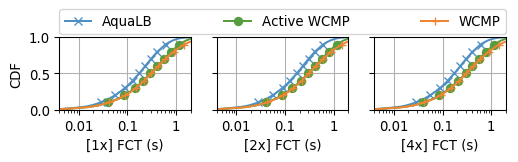

In [40]:
methods2plot = methods
rate = 400
r = np.arange(len(methods2plot))

fig, axs = plt.subplots(1, 3, figsize=(6, 1), dpi=96, sharex=True, sharey=True)
conf_diff = [1, 2, 4]
for i, (setup, xlim, title) in enumerate(zip(configs, [[4e-3, 2]]*3, ['{}x #CPU Diff.'.format(i) for i in conf_diff])):


    for method in methods2plot:
        v = fct_all[setup][method][rate]['page_load_time']
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
        axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])
    

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    if i == 0:
        plt.sca(axs[i])
        axs[i].legend(bbox_to_anchor=(0., 1.05, 3.4, .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
        axs[i].set_ylabel('CDF')
    else:
        axs[i].set_yticks([0.5], [''])
    
    axs[i].set_xlabel('[{}x] FCT (s)'.format(conf_diff[i]))
    axs[i].set_xscale('log')
    axs[i].set_xlim(xlim)
    plt.xticks([0.01, 0.1, 1.0], [0.01, 0.1, 1])
    axs[i].grid(True)

## 24-Hour WikiPedia Trace

### Wiki Trace

In [43]:
methods = ['ecmp', 'wcmp', 'active-wcmp', 'aqualb']
samples = ['hour{}.csv'.format(i) for i in range(24)]
config_prefix = ['conf0{}'.format(i) for i in [1]]
trace = 'wiki'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
for method in methods:
    print("=== running method {} ===".format(method))
    for sample in samples:
        print(">> sample {}".format(sample))
        for config in config_prefix:
            run_pipeline(
                lb_method=method,
                trace=trace,
                experiment=EXPERIMENT,
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config,
                clip_n=clip_n,
                n_episode=n_episode,
                episode_base=episode_base
                remote_servers=remote_servers,
                clt_server=clt_server,
            )        

### Load Dataset

In [59]:
conf = 'conf01'
hour_rate = {}
page_load_time_res = {}
ratios_all = {}
hours = range(24)
for h in hours:
    # traffic rate
    lines = tu.read_file('../../data/trace/wiki/hour{}.csv'.format(h))
    # parse lines into an array w/ three columns: [ts, url, url_type (static, wiki)]
    query_info = []
    for l in lines:
        ts, url = l.split('\t')
        ts = float(ts)
        url_type = 'wiki' if '/wiki/index.php' in url else 'static'
        query_info.append([ts, url, url_type])
    n_wiki = len([_ for _ in query_info if _[-1] == 'wiki'])/600
    n_static = len([_ for _ in query_info if _[-1] == 'static'])/600
    hour_rate[h] = {'wiki': n_wiki, 'static': n_static}
    
    # page load time
    config = 'hour{}-{}'.format(h, conf)
    page_load_time_res[config] = {}
    for method in methods:
        print(">> loading method:", method)
        _task, _dir = tu.get_task_name_dir(EXPERIMENT, trace, method, sample='hour{:d}'.format(h), alias=conf)
        page_load_time_res[config][method] = get_page_load_time(_dir.replace('results', 'reproduce'))
    
    # weight ratio
    ratios_all[config] = {}
    method = 'aqualb'
    filename = os.path.join(ROOT_DIR, 'data', 'reproduce', 'online', 'wiki', method, config, '1_log_ep0/logger.log')
    lines = tu.read_file(filename)[15:]
    action = np.array([[float(n) for n in l.split(':')[-1].split('|')] for l in lines if 'Last action' in l])
    ratios_all[config][method] = action[int(action.shape[0]/2):int(action.shape[0]*0.9), :3].mean(axis=1) / action[int(action.shape[0]/2):int(action.shape[0]*0.9), 3:].mean(axis=1)    
    
    print("hour {} done!".format(h))

>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 0 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 1 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 2 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 3 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 4 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 5 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 6 done!
>> loading method: ecmp
>> loading method: wcmp
>> loading method: active-wcmp
>> loading method: aqualb
hour 7 done!
>> loading method: ecmp
>> loading method: wcmp
>> loadi

In [60]:
plt_24h = {}
for method in methods:
    plt_24h[method] = {'Wiki': [], 'Static': []}
    for h in hours:
        if hour_rate[h]['wiki'] <= 328.96: continue
        v = page_load_time_res['hour{}-conf01'.format(h)]        
        plt_24h[method]['Wiki'] += v[method]['plt_wiki']
        plt_24h[method]['Static'] += v[method]['plt_static']

### Plot

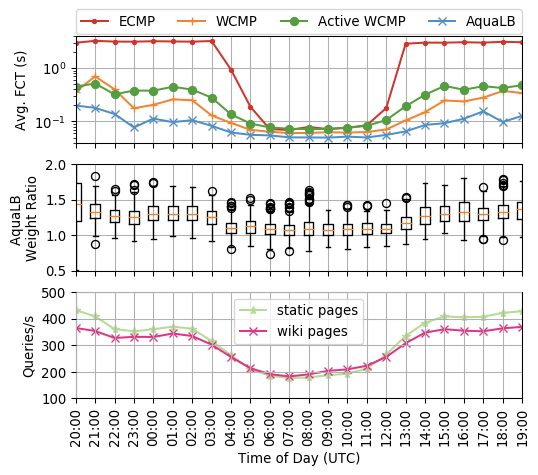

In [69]:
n_subplot = 3
ylims=[[4e-2, 4]] # median
ylabels=['Avg. FCT (s)']
reduce_methods = [np.mean]

fig, axs = plt.subplots(n_subplot, figsize=(6, 5), dpi=96, sharex=True)
for i, ylabel, reduce_method, ylim in zip(range(n_subplot-1), ylabels, reduce_methods, ylims):
    for method in methods:
#         if method in ['hlb-ada']: continue
        v = [reduce_method(page_load_time_res['hour{}-conf01'.format(h)][method]['plt_wiki']) for h in hours]
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]

        axs[i].plot(hours, v, linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

#     axs[i].set_xlim(xlim)
    axs[i].set_ylim(ylim)
    axs[i].grid(True)
    axs[i].set_ylabel(ylabel)
    axs[i].set_yscale('log')
    if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)

i += 1
axs[i].boxplot([ratios_all['hour{}-conf01'.format(h)]['aqualb'] for h in range(24)], positions=range(24))
axs[i].set_ylabel('AquaLB \nWeight Ratio')
axs[i].grid(True)
axs[i].set_ylim([0.5, 2])
        
i += 1
axs[i].plot(hours, [hour_rate[h]['static'] for h in hours], color=COLORS[-6], marker='*', label='static pages')
axs[i].plot(hours, [hour_rate[h]['wiki'] for h in hours], color=COLORS[-1], marker='x', label='wiki pages')
# axs[i].stackplot(hours, [[hour_rate[h]['wiki'] for h in hours], [hour_rate[h]['static'] for h in hours]], colors=COLORS[6:8], labels=['wiki pages', 'static pages'])

plt.xticks(hours, ['{:02}:00'.format(int((i+20)%24), i) for i in range(25)], rotation=90)
axs[i].set_axisbelow(False)
plt.yticks([100, 200, 300, 400, 500], ['{}'.format(i) for i in [100, 200, 300, 400, 500]])
plt.xlabel("Time of Day (UTC)")
plt.ylabel("Queries/s")
axs[i].grid(True)
plt.legend(loc='upper center')
plt.xlim([0, 23])
plt.show()

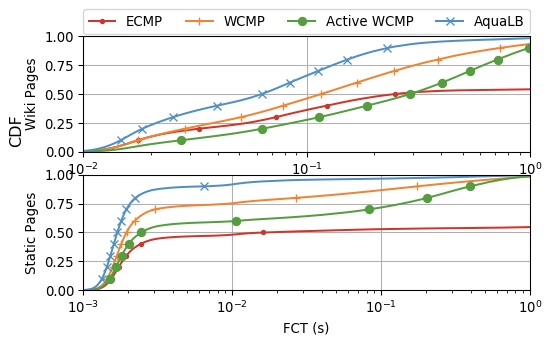

In [65]:
xlims=[[1e-2, 1],[1e-3, 1]]
n_subplots = 2
fig, axs = plt.subplots(n_subplots, figsize=(6, 3.5), dpi=96, sharex=False, sharey=True)
fig.suptitle('CDF', position=(0.01, .65), rotation='vertical')
for i, ylabel, xlim in zip(range(n_subplots), ['Wiki', 'Static'], xlims):
    for method in methods:
        v = plt_24h[method][ylabel]
        color = COLORS_DICT[method]
        marker = MARKER_DICT[method]
        linestyle = LINESTYLE_DICT[method]
        percentiles = [np.percentile(v, p) for p in range(0, 110, 10)]
        axs[i].semilogx(np.sort(v), np.linspace(0, 1, len(v), endpoint=False), color=color)
        axs[i].semilogx(percentiles, np.linspace(0, 1, 11, endpoint=True), linestyle='', marker=marker, color=color)
        axs[i].plot([0.], [0.], linestyle=linestyle, marker=marker, color=color, label=METHOD_MAPPER[method])

    axs[i].set_xlim(xlim)
    axs[i].set_ylim([0.,1.])
    axs[i].grid(True)
    axs[i].set_ylabel('{} Pages'.format(ylabel))
    if i == n_subplots-1: axs[i].set_xlabel('FCT (s)')
    if i == 0: axs[i].legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
           ncol=4, mode="expand", borderaxespad=0.)
plt.show()

## Overhead Analysis

### Poisson For-Loop Trace

In [34]:
methods = ['ecmp_time', 'wcmp_time', 'aqualb_time']
samples = ['rate_{}.csv'.format(i) for i in [500]]
config_prefix = ['1x-1lb-176cpu']
trace = 'poisson_for_loop'
from_orig=None
clip_n = 200000
n_episode = 2
episode_base = 0
remote_servers = [0]
clt_server = 0

In [ ]:
for method in methods:
    print("=== running method {} ===".format(method))
    for sample in samples:
        print(">> sample {}".format(sample))
        for config in config_prefix:
            run_pipeline(
                lb_method=method,
                trace=trace,
                experiment=EXPERIMENT,
                sample=sample,
                from_orig=from_orig,
                config_file_prefix=config,
                clip_n=clip_n,
                n_episode=n_episode,
                episode_base=episode_base
                remote_servers=remote_servers,
                clt_server=clt_server,
            )        

### Load Dataset

In [83]:
r = 500
methods = ['wcmp', 'maglev', 'aqualb']
clib_dict = {
}
for m in methods:
    clib_dict[m] = {
        0: [],
        1: [],
        2: []
    }
    lines = [l.split('@dt = ')[-1].strip(' ') for l in tu.read_file('../../data/reproduce/online/poisson_for_loop/{}/rate_{}-1x-1lb-176cpu/clib.log'.format(m, r)) if '@dt' in l]
    for l in lines:
        dt, packet_type = float(l.split('|')[0].strip(']')), int(l.split('|')[1].strip(']'))
        clib_dict[m][packet_type].append(dt)

### Plot

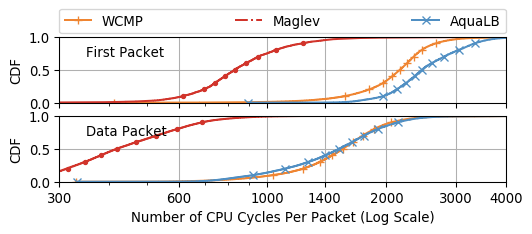

In [89]:
text_x = 350
fig, axs = plt.subplots(2, figsize=(6,2), dpi=96, sharex=True, sharey=True)
plt.sca(axs[0])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][0]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.plot(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])
plt.legend(bbox_to_anchor=(0., 1.05, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0.)
plt.grid()
plt.text(text_x, 0.7, 'First Packet')
plt.ylabel("CDF")
plt.xticks([600, 1000, 2000, 4000], ['', '', '', ''])

plt.sca(axs[1])
# plot with data as the data source
for m in methods:
    c, marker = COLORS_DICT[m], MARKER_DICT[m]
    data = clib_dict[m][1]
    percentiles = [np.percentile(data, p) for p in range(0, 110, 10)]
    plt.plot(np.sort(data), np.linspace(0, 1, len(data), endpoint=False), color=c)
    plt.plot(percentiles, np.linspace(0, 1, 11, endpoint=True), marker, color=c)
    plt.plot(0, -1, '-{}'.format(marker), color=c, label=METHOD_MAPPER[m])
plt.text(text_x, 0.7, 'Data Packet')

plt.xscale('log')
plt.ylabel("CDF")
plt.xlabel('Number of CPU Cycles Per Packet (Log Scale)')
plt.grid()
plt.xlim([300, 4000])
plt.ylim([0, 1])
plt.xticks([300, 600, 1000, 1400, 2000, 3000, 4000], [300, 600, 1000, 1400, 2000, 3000, 4000])
plt.show()